In [85]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
file_path = 'https://github.com/rosenfa/ai/blob/master/news-israel.xlsx?raw=true'
file_path_pal = 'https://github.com/rosenfa/ai/blob/master/news-pal.xlsx?raw=true'
df_israel = pd.read_excel(file_path)
df_pal = pd.read_excel(file_path_pal)

In [86]:
df_israel['pro_israel'] = 1
df_pal['pro_israel'] = 0

In [87]:
combined_df = pd.concat([df_israel, df_pal], ignore_index=True)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.drop('Location', axis=1, inplace=True)

In [88]:
combined_df

,Content,pro_israel
0,Residents of Brazils poorest neighbourhoods sa...,0
1,#BREAKING Gov't Media Office warns of a massac...,0
2,"7 weeks after Hamas massacre, Shani Gabay, pre...",1
3,US Blinken urges Israel to stop settler violen...,0
4,"Danielle Haas, who worked at HRW for over 13 y...",1
...,...,...
945,Andrew Tate: â˜The Israelis are genociding the...,1
946,US said to delay shipment of weapons for secur...,1
947,South Africa to host BRICS summit on Israel-Ha...,1
948,"In some of those cases, we had 21 family membe...",0


In [89]:
content_pal = df_pal['Content']
content_isr = df_israel['Content']

In [90]:
# Combine all the text into a single string
all_text_pal = ' '.join(content_pal.dropna())
all_text_isr = ' '.join(content_isr.dropna())

In [91]:
import re
# Define a function to remove non-alphanumeric characters
def remove_special_characters(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

all_text_pal = remove_special_characters(all_text_pal)
all_text_isr = remove_special_characters(all_text_isr)

In [92]:
def createCloud(vectorizer,text):
  X = vectorizer.fit_transform([text])
  feature_names = vectorizer.get_feature_names_out()
  # Create a dictionary with words and their corresponding frequencies
  word_frequencies = dict(zip(feature_names, X.toarray()[0]))
  # Create a WordCloud object
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

  # Display the WordCloud using matplotlib
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

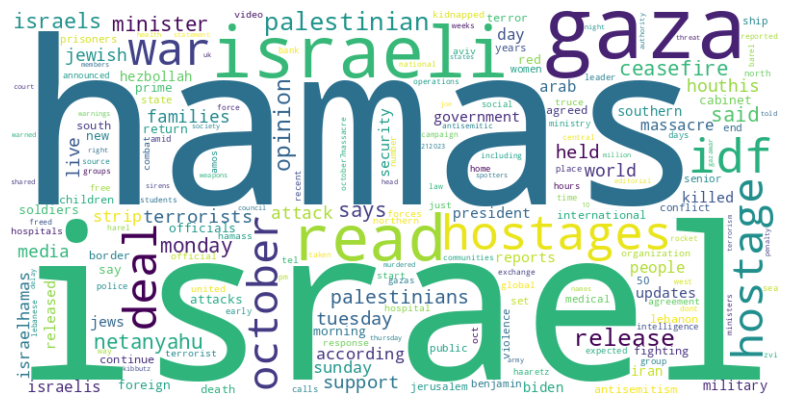

In [93]:
lower_case_isr = all_text_isr.lower()
lower_case_pal = all_text_pal.lower()
vectorizer = CountVectorizer(stop_words='english')
createCloud(vectorizer,lower_case_isr)

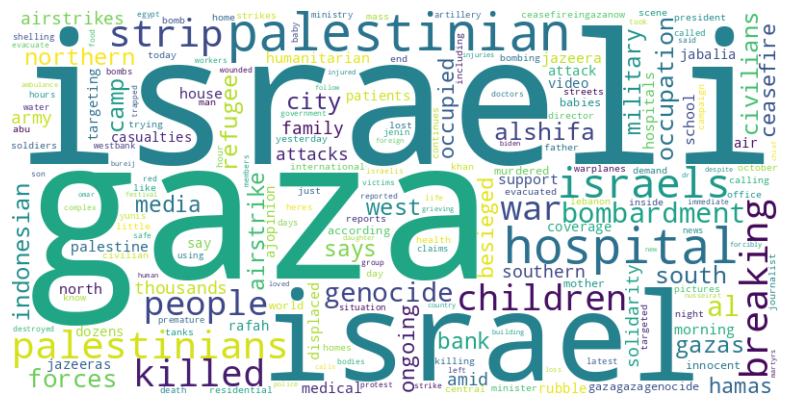

In [94]:
createCloud(vectorizer,lower_case_pal)

In [95]:
from sklearn.feature_selection import mutual_info_classif
X = combined_df['Content']  # Assuming 'content' contains the tweet text
y = combined_df['pro_israel']  # Assuming 'pro_israel' contains the target labels

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the data
X_vectorized = vectorizer.fit_transform(X)

# Compute mutual information (information gain) between each feature (word) and the target variable
mutual_info = mutual_info_classif(X_vectorized, y)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to display feature names and corresponding information gain
word_info_gain_df = pd.DataFrame({'word': feature_names, 'information_gain': mutual_info})

# Sort the DataFrame by information gain in descending order to see words with the greatest influence
word_info_gain_df = word_info_gain_df.sort_values(by='information_gain', ascending=False)

print("Words with the greatest information gain:")
print(word_info_gain_df.head(10))

Words with the greatest information gain:
          word  information_gain
1905     hamas          0.100200
1781      gaza          0.096023
3312      read          0.067261
2262   israeli          0.066367
2236        io          0.064748
274        aje          0.064748
2051  hostages          0.048324
4098        to          0.045339
2049   hostage          0.042707
2066      http          0.042573


In [96]:
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

def find_high_pmi_words(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    # Remove words containing numbers
    words = [word for word in words if not any(char.isdigit() for char in word)]
    # Initialize a BigramCollocationFinder
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(words)
    # Calculate PMI for bigrams
    pmi_scores = finder.score_ngrams(bigram_measures.pmi)
    # Sort by PMI score in descending order
    sorted_pmi_scores = sorted(pmi_scores, key=lambda x: x[1], reverse=True)
    # Filter words with high PMI
    threshold = 2.0  # Adjust as needed
    high_pmi_words = {bigram: pmi for bigram, pmi in sorted_pmi_scores[:5] if pmi > threshold}
    return high_pmi_words

high_pmi_words_pal = find_high_pmi_words(all_text_pal)
high_pmi_words_isr = find_high_pmi_words(all_text_isr)

print("Top 5 high PMI bigrams for pro-Palestinian tweets (after removing stopwords and words with numbers):")
for bigram, pmi in high_pmi_words_pal.items():
    print(bigram, "PMI:", pmi)

print("\nTop 5 high PMI bigrams for pro-Israel tweets (after removing stopwords and words with numbers):")
for bigram, pmi in high_pmi_words_isr.items():
    print(bigram, "PMI:", pmi)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 5 high PMI bigrams for pro-Palestinian tweets (after removing stopwords and words with numbers):
('AI', 'deciding') PMI: 12.83190098619642
('Abdulla', 'submitted') PMI: 12.83190098619642
('Abdulrahman', 'alThani') PMI: 12.83190098619642
('Abed', 'Rabbo') PMI: 12.83190098619642
('Activists', 'occupy') PMI: 12.83190098619642

Top 5 high PMI bigrams for pro-Israel tweets (after removing stopwords and words with numbers):
('AI', 'landscape') PMI: 12.927963101003467
('Accords', 'signed') PMI: 12.927963101003467
('Actor', 'Melissa') PMI: 12.927963101003467
('Air', 'Maroc') PMI: 12.927963101003467
('Alumni', 'Club') PMI: 12.927963101003467


In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

def find_high_bayes_factor_words(texts_class_1, texts_class_2, top_n=10):
    # Combine the texts from both classes
    all_texts = texts_class_1 + texts_class_2
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(all_texts)
    # Train Naive Bayes classifier
    y = np.array([0] * len(texts_class_1) + [1] * len(texts_class_2))  # 0 for class 1, 1 for class 2
    classifier = MultinomialNB()
    classifier.fit(X, y)
    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())
    # Get log probabilities from the classifier
    log_probs = classifier.feature_log_prob_  # log probabilities for each class
    # Calculate Bayes Factor for each word
    bayes_factors = log_probs[0] - log_probs[1]  # log(count_in_class_1 / count_in_class_2)
    # Get top N words with highest Bayes Factor
    top_indices = np.argsort(bayes_factors)[::-1][:top_n]
    top_words_with_values = {feature_names[i]: bayes_factors[i] for i in top_indices}
    return top_words_with_values

# Example usage:
top_words_pal = find_high_bayes_factor_words(content_pal.dropna().tolist(), content_isr.dropna().tolist(), top_n=10)

print("Top 10 words with high Bayes Factor for pro-Palestinian tweets:")
for word, bayes_factor in top_words_pal.items():
    print(word, "Bayes Factor:", bayes_factor)


Top 10 words with high Bayes Factor for pro-Palestinian tweets:
io Bayes Factor: 2.5795224530163585
aje Bayes Factor: 2.5795224530163585
gazagenocide Bayes Factor: 2.1456539383289925
bombardment Bayes Factor: 2.135996686542244
http Bayes Factor: 1.977548191581704
genocide Bayes Factor: 1.8423699516013992
breaking Bayes Factor: 1.8279421073037057
al Bayes Factor: 1.8144396614110123
hospital Bayes Factor: 1.7940988855998237
occupation Bayes Factor: 1.7648122018463273


In [98]:
# Find top words with high Bayes Factor for pro-Israel tweets
top_words_isr = find_high_bayes_factor_words(content_isr.dropna().tolist(), content_pal.dropna().tolist(), top_n=10)
print("Top 10 words with high Bayes Factor for pro-Israel tweets:")
for word, bayes_factor in top_words_isr.items():
    print(word, "Bayes Factor:", bayes_factor)

Top 10 words with high Bayes Factor for pro-Israel tweets:
hostages Bayes Factor: 2.546845672698402
hostage Bayes Factor: 2.4661985221241363
read Bayes Factor: 2.2816986934603305
deal Bayes Factor: 2.176405608423387
idf Bayes Factor: 2.041981538012923
via Bayes Factor: 1.9587617597027416
hamas Bayes Factor: 1.9376060887701119
release Bayes Factor: 1.8639449866752704
opinion Bayes Factor: 1.794815137706684
live Bayes Factor: 1.6679627051191792


In [99]:
combined_df

,Content,pro_israel
0,Residents of Brazils poorest neighbourhoods sa...,0
1,#BREAKING Gov't Media Office warns of a massac...,0
2,"7 weeks after Hamas massacre, Shani Gabay, pre...",1
3,US Blinken urges Israel to stop settler violen...,0
4,"Danielle Haas, who worked at HRW for over 13 y...",1
...,...,...
945,Andrew Tate: â˜The Israelis are genociding the...,1
946,US said to delay shipment of weapons for secur...,1
947,South Africa to host BRICS summit on Israel-Ha...,1
948,"In some of those cases, we had 21 family membe...",0


**Create a decision tree model with the stop words and see which words are the most impactful. Then create a model without the stop words and see which ones do better**

**Use A TFIDF Vectorizer**

**Also, see which features were most important**

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Vectorize the text data (convert text into numerical features)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Assuming your dataframe has columns 'text' for tweet content and 'label' for classification (pro-Israel or pro-Palestine)
# If your dataframe has different column names, replace them accordingly

# Separate features (X) and target variable (y)
X = combined_df['Content']  # Assuming 'text' contains the content of the tweets
y = combined_df['pro_israel']  # Assuming 'label' contains the classification (pro-Israel or pro-Palestine)



def decisionTreeModel(X_vectorized):
  # Create a decision tree classifier
  tree_classifier = DecisionTreeClassifier()

  # Create StratifiedKFold object for 10-fold cross-validation
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  # Perform 10-fold cross-validation
  cv_scores = cross_val_score(tree_classifier, X_vectorized, y, cv=kfold)

  tree_classifier.fit(X_vectorized, y)

# Get feature importances
  feature_importances = tree_classifier.feature_importances_

  # Get the vocabulary (words) from the vectorizer
  vocabulary = vectorizer.get_feature_names_out()

  # Create a DataFrame to display feature importances
  importance_df = pd.DataFrame({'Feature': vocabulary, 'Importance': feature_importances})

  # Sort DataFrame by importance (descending)
  importance_df = importance_df.sort_values(by='Importance', ascending=False)



  # Print cross-validation scores
  print("Cross-validation scores:", cv_scores)
  print("Mean accuracy:", cv_scores.mean())

  # Display the top N most important features
  top_n = 10  # Number of top features to display
  print()
  print(f"Top {top_n} most important features:")
  print(importance_df.head(top_n))


In [101]:
# Vectorize the text data (convert text into numerical features)
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
X_vectorized = vectorizer.fit_transform(X)
decisionTreeModel(X_vectorized)

Cross-validation scores: [0.83157895 0.83157895 0.81052632 0.88421053 0.76842105 0.85263158
 0.85263158 0.78947368 0.83157895 0.82105263]
Mean accuracy: 0.8273684210526318

Top 10 most important features:
      Feature  Importance
395     hamas    0.169429
365      gaza    0.096093
702      read    0.072229
444       idf    0.064151
468   israeli    0.035879
927       via    0.032461
430  hostages    0.032049
51        aje    0.030991
53         al    0.026748
567    monday    0.020176



**Use A Count Vectorizer and see if it performs better than the tfidf model**

In [102]:
# Vectorize the text data (convert text into numerical features)
vectorizer2 = CountVectorizer(max_features=1000)  # You can adjust max_features as needed
X_New_vectorized = vectorizer2.fit_transform(X)
decisionTreeModel(X_New_vectorized)

Cross-validation scores: [0.84210526 0.85263158 0.86315789 0.89473684 0.77894737 0.86315789
 0.83157895 0.86315789 0.90526316 0.83157895]
Mean accuracy: 0.8526315789473685

Top 10 most important features:
      Feature  Importance
395     hamas    0.164038
365      gaza    0.094345
702      read    0.064005
468   israeli    0.053722
444       idf    0.052570
51        aje    0.035473
53         al    0.027495
430  hostages    0.027336
567    monday    0.021739
927       via    0.020452


**Once I have made the decision tree, make the random forest and see if we get better results**

**Use TF-IDF as my tokenizer**

In [103]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest classifier
def rfClassifier(X_vectorized):
  forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators as needed

  # Create StratifiedKFold object for 10-fold cross-validation
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  # Perform 10-fold cross-validation
  cv_scores = cross_val_score(forest_classifier, X_vectorized, y, cv=kfold)

  # Print cross-validation scores
  print("Cross-validation scores:", cv_scores)
  print("Mean accuracy:", cv_scores.mean())

In [104]:
rfClassifier(X_vectorized)

Cross-validation scores: [0.86315789 0.91578947 0.90526316 0.93684211 0.88421053 0.91578947
 0.93684211 0.91578947 0.96842105 0.88421053]
Mean accuracy: 0.9126315789473682


**Use Countvecotirzer to see if we improve**

In [105]:
rfClassifier(X_New_vectorized)

Cross-validation scores: [0.90526316 0.91578947 0.90526316 0.91578947 0.87368421 0.91578947
 0.93684211 0.89473684 0.91578947 0.89473684]
Mean accuracy: 0.9073684210526316


**Use GradientBoost to see if we get better results**

In [106]:
from sklearn.ensemble import GradientBoostingClassifier
# Create a Gradient Boosting classifier
def xgb(X_vectorized):
  gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)  # You can adjust n_estimators and learning_rate as needed

  # Create StratifiedKFold object for 10-fold cross-validation
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  # Perform 10-fold cross-validation
  cv_scores = cross_val_score(gb_classifier, X_vectorized, y, cv=kfold)

  # Print cross-validation scores
  print("Cross-validation scores:", cv_scores)
  print("Mean accuracy:", cv_scores.mean())

In [107]:
xgb(X_vectorized)

Cross-validation scores: [0.90526316 0.90526316 0.91578947 0.91578947 0.86315789 0.92631579
 0.89473684 0.86315789 0.92631579 0.84210526]
Mean accuracy: 0.8957894736842104


In [108]:
xgb(X_New_vectorized)

Cross-validation scores: [0.92631579 0.90526316 0.93684211 0.91578947 0.86315789 0.93684211
 0.91578947 0.88421053 0.92631579 0.84210526]
Mean accuracy: 0.9052631578947367


**Use a model but set the minimum times a words must appear to 5x. I tried using 2 and 3 and this was the best that I got so far**

In [111]:
# Vectorize the text data (convert text into numerical features)
vectorizer2 = CountVectorizer(max_features=1000,min_df=5) #min df only includes the words that come up a minimmum of 5x in the corpus
X_New_vectorized = vectorizer2.fit_transform(X)
rfClassifier(X_New_vectorized)

Cross-validation scores: [0.92631579 0.93684211 0.91578947 0.91578947 0.89473684 0.94736842
 0.94736842 0.90526316 0.93684211 0.90526316]
Mean accuracy: 0.9231578947368421


Finally, let's try removing the stop words and see how we do

In [110]:
vectorizer2 = CountVectorizer(max_features=1000,stop_words='english')  # You can adjust max_features as needed
X_New_vectorized = vectorizer2.fit_transform(X)
rfClassifier(X_New_vectorized)

Cross-validation scores: [0.91578947 0.90526316 0.92631579 0.92631579 0.90526316 0.92631579
 0.97894737 0.89473684 0.93684211 0.89473684]
Mean accuracy: 0.9210526315789475


**Remove the stopwords and only include words that come up 5x**

In [112]:
vectorizer2 = CountVectorizer(max_features=1000,stop_words='english',min_df=5)  # You can adjust max_features as needed
X_New_vectorized = vectorizer2.fit_transform(X)
rfClassifier(X_New_vectorized)

Cross-validation scores: [0.90526316 0.93684211 0.91578947 0.90526316 0.91578947 0.92631579
 0.90526316 0.89473684 0.91578947 0.90526316]
Mean accuracy: 0.9126315789473685


Unsure why, but the min amt of times a word comes up is 5, gives me the very good results, when I remove the stop words I get really good results, but when I do both it makes my model worse.